# Probability Mass Functions

In the previous chapter we represented distributions using a `Hist` object, which contains a set of quantities and their frequencies -- that is, the number of times each one appears.
In this chapter we'll introduce another way to represent a distribution: a `Pmf` object, which contains a set of quantities and their probabilities.

And we'll use `Pmf` objects to compute the mean and variance of a distribution, and the skewness, which indicates whether it is skewed to the left or right.
Finally, we will explore how a phenomenon called the "inspection paradox" can cause a sample to give a biased view of a distribution.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## PMFs

A `Pmf` object is like a `Hist` that contains probabilities instead of frequencies.
So one way to make a `Pmf` is to start with a `Hist`.
For example, here's a `Hist` that represents the distribution of values in a short sequence.

In [4]:
from empiricaldist import Hist

hist = Hist.from_seq([1, 2, 2, 3, 5])
hist

,freqs
1,1
2,2
3,1
5,1


<IPython.core.display.Javascript object>

The sum of the frequencies is the size of the original sequence.

In [5]:
n = hist.sum()
n

5

<IPython.core.display.Javascript object>

If we divide the frequencies by `n`, they represent proportions, rather than counts.

In [6]:
pmf = hist / n
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


<IPython.core.display.Javascript object>

This result indicates that 20% of the values in the sequence are 1, 40% are 2, and so on.

We can also think of these proportions as probabilities in the following sense: if we choose a random value from the original sequence, the probability we choose the value 1 is 0.2, the probability we choose the value 2 is 0.4, and so on.

Because we divided through by `n`, the sum of the probabilities is 1, which means that this distribution is **normalized**.

In [7]:
pmf.sum()

1.0

<IPython.core.display.Javascript object>

A normalized `Hist` object represents a **probability mass function** (PMF), so-called because probabilities associated with discrete quantities are also called "probability masses".

The `empiricaldist` library provides a `Pmf` object that represents a probability mass function, so instead of creating a `Hist` object and then normalizing it, we can create a `Pmf` object directly.

In [8]:
from empiricaldist import Pmf

pmf = Pmf.from_seq([1, 2, 2, 3, 5])
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


<IPython.core.display.Javascript object>

The `Pmf` is normalized so the total probability is 1.

In [9]:
pmf.sum()

1.0

<IPython.core.display.Javascript object>

`Pmf` and `Hist` objects are similar in many ways.
To look up the probability associated with a value, we can use the bracket operator.

In [10]:
pmf[2]

0.4

<IPython.core.display.Javascript object>

Or use parentheses to call the `Pmf` like a function.

In [11]:
pmf(2)

0.4

<IPython.core.display.Javascript object>

To assign a probability to a quantity, you have to use the bracket operator.

In [12]:
pmf[2] = 0.2
pmf(2)

0.2

<IPython.core.display.Javascript object>

You can modify an existing `Pmf` by incrementing the probability associated with a value:

In [13]:
pmf[2] += 0.3
pmf[2]

0.5

<IPython.core.display.Javascript object>

Or you can multiply a probability by a factor:

In [14]:
pmf[2] *= 0.5
pmf[2]

0.25

<IPython.core.display.Javascript object>

If you modify a `Pmf`, the result may not be normalized -- that is, the probabilities may no longer add up to 1.

In [15]:
pmf.sum()

0.8500000000000001

<IPython.core.display.Javascript object>

The `normalize` method renormalizes the `Pmf` by dividing through by the sum -- and returning the sum. 

In [16]:
pmf.normalize()

0.8500000000000001

<IPython.core.display.Javascript object>

`Pmf` objects provide a `copy` method so you can make and modify a copy without affecting the original.

In [17]:
pmf.copy()

,probs
1,0.235294
2,0.294118
3,0.235294
5,0.235294


<IPython.core.display.Javascript object>

Like a `Hist` object, a `Pmf` object has a `qs` attribute that accesses the quantities and a `ps` attribute that accesses the probabilities.

It also has a `bar` method that plots the `Pmf` as a bar graph and a `plot` method that plots it as a line graph.

## Summary Statistics

In Section XXX we computed the mean of a sample by adding up the elements and dividing by `n`.
Here's a simple example.

In [18]:
seq = [1, 2, 2, 3, 5]

mean = np.sum(seq) / len(seq)
mean

2.6

<IPython.core.display.Javascript object>

Now suppose we compute the PMF of the values in the sequence.

In [19]:
pmf = Pmf.from_seq(seq)

<IPython.core.display.Javascript object>

Given the `Pmf`, we can still compute the mean, but the process is different -- we have to multiply the probabilities and quantities and add up the products.

In [20]:
mean = np.sum(pmf.ps * pmf.qs)
mean

2.6

<IPython.core.display.Javascript object>

The `mean` method does the same thing.

In [21]:
pmf.mean()

2.6

<IPython.core.display.Javascript object>

Notice that we *don't* have to divide by `n`, because we already did that when we normalized the `Pmf`.

Give a `Pmf`, we can compute the variance by computing the deviation of each quantity from the mean.

In [22]:
deviations = pmf.qs - mean

<IPython.core.display.Javascript object>

Then we multiply the squared deviations by the probabilities and add up the products.

In [23]:
var = np.sum(pmf.ps * deviations**2)
var

1.84

<IPython.core.display.Javascript object>

The `var` method does the same thing.

In [24]:
pmf.var()

1.84

<IPython.core.display.Javascript object>

From the variance, we can compute the standard deviation in the usual way.

In [25]:
np.sqrt(var)

1.3564659966250536

<IPython.core.display.Javascript object>

Or the `std` method does the same thing.

In [26]:
pmf.std()

1.3564659966250536

<IPython.core.display.Javascript object>

`Pmf` also provides a `mode` method that finds the value with the highest probability.

In [27]:
pmf.mode()

2

<IPython.core.display.Javascript object>

## The Class Size Paradox

As an example of what we can do with `Pmf` objects, let's consider a phenomenon I call "the class size paradox."

At many American colleges and universities, the student-to-faculty ratio is about 10:1.
But students are often surprised to discover that their average class size is bigger than 10. There are two reasons for the discrepancy:

-   Students typically take 4 or 5 classes per semester, but professors often teach 1 or 2.

-   The number of students who enjoy a small class is small, but the number of students in a large class is large.

The first effect is obvious, at least once it is pointed out; the second is more subtle.
Let's look at an example.
Suppose that a college offers 65 classes in a given semester, and we are given the number of classes in each of the following size ranges.

In [28]:
ranges = pd.interval_range(start=5, end=50, freq=5, closed="left")
ranges.name = "class size"

data = pd.DataFrame(index=ranges)
data["count"] = [8, 8, 14, 4, 6, 12, 8, 3, 2]
data

,count
class size,
"[5, 10)",8
"[10, 15)",8
"[15, 20)",14
"[20, 25)",4
"[25, 30)",6
"[30, 35)",12
"[35, 40)",8
"[40, 45)",3
"[45, 50)",2


<IPython.core.display.Javascript object>

Since we don't know the sizes of the classes in each range, let's assume that all sizes are at the midpoint of the range.

In [30]:
sizes = ranges.left + 2
sizes

Index([7, 12, 17, 22, 27, 32, 37, 42, 47], dtype='int64')

<IPython.core.display.Javascript object>

Now let's make a `Pmf` that represents the distribution of class sizes.
Because we already know the frequency of each size, we don't have to use `from_seq`; instead, we can create a `Pmf` directly, passing as arguments the counts, sizes, and name.
When we normalize the new `Pmf`, the result is the sum of the counts.

In [31]:
counts = data["count"]
actual_pmf = Pmf(counts, sizes, name="actual")
actual_pmf.normalize()

65

<IPython.core.display.Javascript object>

If you ask the college for the average class size, they report the mean of this distribution, which is 23.7.

In [32]:
print("mean", actual_pmf.mean())

mean 23.692307692307693


<IPython.core.display.Javascript object>

But if you survey a group of students, ask them how many students are in their classes, and compute the mean, the average is bigger.
Let's see how much bigger.

The following function takes the actual `Pmf` of class sizes and makes a new `Pmf` that represents the class sizes as seen by students.
The quantities in the two distributions are the same, but the probabilities in the distribution are multiplied by the quantities, because in a class with size `x`, there are `x` students who observe that class.
So the probability of observing a class is proportional to its size.

In [33]:
def bias(pmf, name):
    qs = pmf.qs
    ps = pmf.ps * pmf.qs

    new_pmf = Pmf(ps, pmf.qs, name=name)
    new_pmf.normalize()
    return new_pmf

<IPython.core.display.Javascript object>

Now we can compute the biased `Pmf` as observed by students.

In [35]:
observed_pmf = bias(actual_pmf, name="observed")

<IPython.core.display.Javascript object>

Here's what the two distributions look like.

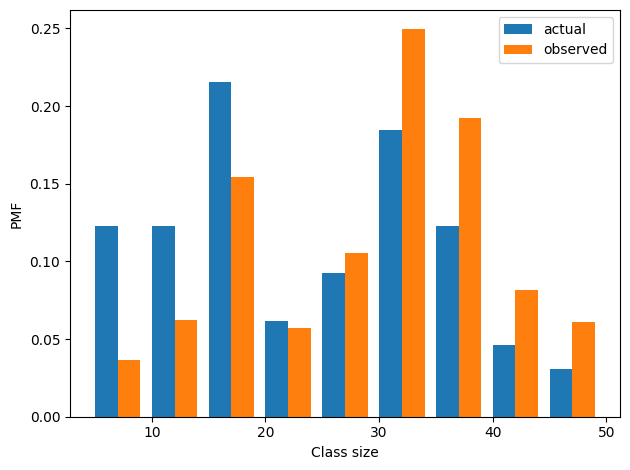

<IPython.core.display.Javascript object>

In [36]:
from thinkstats import two_bar_plots

two_bar_plots(actual_pmf, observed_pmf, width=2)
decorate(xlabel="Class size", ylabel="PMF")

In the observed distribution there are fewer small classes and more large ones.
And the mean is 29.1, almost 25% higher than the actual mean.

In [37]:
observed_pmf.mean()

29.123376623376622

<IPython.core.display.Javascript object>

It is also possible to invert this operation.
Suppose you want to find the distribution of class sizes at a college, but you can't get reliable data.
One option is to choose a random sample of students and ask how many students are in their classes.

The result would be biased for the reasons we've just seen, but you can use it to estimate the actual distribution.
Here's the function that unbiases a `Pmf` by dividing the probabilities by the sizes.

In [38]:
def unbias(pmf, name):
    qs = pmf.qs
    ps = pmf.ps / pmf.qs

    new_pmf = Pmf(ps, pmf.qs, name=name)
    new_pmf.normalize()
    return new_pmf

<IPython.core.display.Javascript object>

And here's the result.

In [39]:
debiased_pmf = unbias(observed_pmf, "debiased")
debiased_pmf.mean()

23.692307692307693

<IPython.core.display.Javascript object>

The mean of the debiased `Pmf` is the same as the mean of the actual distribution we started with.
If you think this example is interesting, you might like Chapter 2 of *Probably Overthinking It*, which includes this and several other examples of what's called the "inspection paradox".

## NSFG Data

In the previous chapter, we plotting histograms for the distributions of pregnancy lengths for first babies and others.
But the sizes of the groups are not the same, so we can't compare the histograms directly.
Because PMFs are normalized so they add up to 1, we can compare them.

In [40]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

Again, we can use `read_fem_preg` to read the pregnancy file and use the `query` method to select live births.

We can use `birthord` to separate first babies and others into two groups.

In [63]:
from nsfg import read_fem_preg


def get_nsfg_groups():
    """Read the NSFG pregnancy file and split into groups.
    
    returns: all live births, first babies, other babies
    """
    preg = read_fem_preg()
    live = preg.query("outcome == 1")
    firsts = live.query("birthord == 1")
    others = live.query("birthord != 1")
    return live, firsts, others

<IPython.core.display.Javascript object>

In [64]:
live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

And make a `Pmf` for the pregnancy lengths in each group.

In [43]:
first_pmf = Pmf.from_seq(firsts["prglngth"], name="firsts")
other_pmf = Pmf.from_seq(others["prglngth"], name="others")

<IPython.core.display.Javascript object>

Here are the PMFs of pregnancy length for first babies and others, plotted as bar graphs.

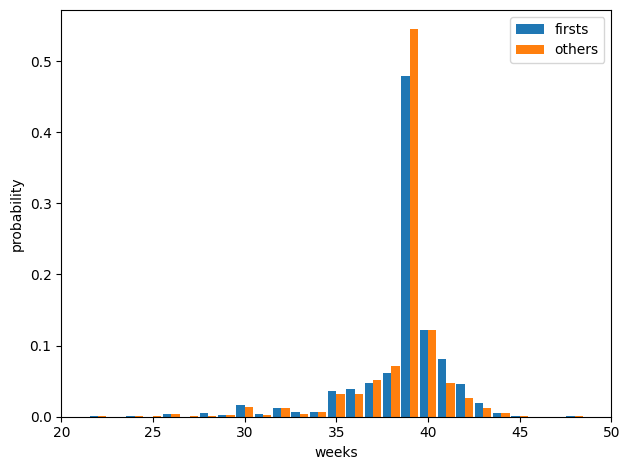

<IPython.core.display.Javascript object>

In [44]:
two_bar_plots(first_pmf, other_pmf)
decorate(xlabel="weeks", ylabel="probability", xlim=[20, 50])

By plotting the PMF instead of the histogram, we can compare the two distributions without being misled by the difference in sample size.
Based on this figure, first babies seem to be less likely than others to arrive on time (week 39) and more likely to be late (weeks 41 and 42).

## Other Visualizations

Histograms and PMFs are useful while you are exploring data and trying to identify patterns and relationships.
Once you have an idea what is going on, a good next step is to design a visualization that makes the patterns you have identified as clear as possible.

In the NSFG data, the biggest differences in the distributions are near the mode.
So it makes sense to zoom in on that part of the graph, and select data from weeks 35 to 46.

When we call a `Pmf` object like a function, we can look up a sequence of quantities and get a sequence of probabilities.

In [45]:
weeks = range(35, 46)
first_pmf(weeks)

array([0.03602991, 0.03897575, 0.04713347, 0.06163608, 0.4790392 ,
       0.12145932, 0.08157716, 0.04645366, 0.01971448, 0.00521187,
       0.00135962])

<IPython.core.display.Javascript object>

In [46]:
other_pmf(weeks)

array([0.03210137, 0.03146779, 0.05216473, 0.07074974, 0.54466737,
       0.12249208, 0.04794087, 0.02597677, 0.01288279, 0.00485744,
       0.00084477])

<IPython.core.display.Javascript object>

So we can compute the differences in the probabilities like this.

In [47]:
diffs = first_pmf(weeks) - other_pmf(weeks)
diffs

array([ 0.00392854,  0.00750796, -0.00503126, -0.00911366, -0.06562817,
       -0.00103276,  0.03363629,  0.02047689,  0.00683169,  0.00035443,
        0.00051485])

<IPython.core.display.Javascript object>

Here's what they look like, multiplied by 100 to express the differences in percentage points.

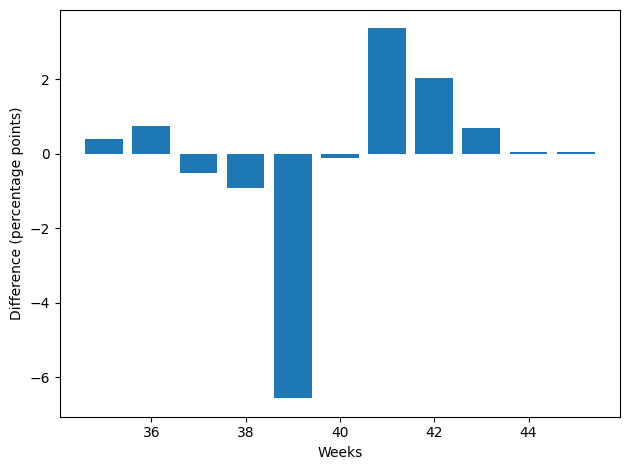

<IPython.core.display.Javascript object>

In [48]:
plt.bar(weeks, diffs * 100)
decorate(xlabel="Weeks", ylabel="Difference (percentage points)")

This figure makes the pattern clearer: first babies are less likely to be born in week 39, and somewhat more likely to be born in weeks 41 and 42.

For now we can't be sure this effect is real -- it might be due to random variation.
We'll revisit that question in Chapter xxx.

## Glossary

-   **Probability mass function (PMF)**: a representation of a distribution as a function that maps from values to probabilities.

-   **probability**: A frequency expressed as a fraction of the sample size.

-   **normalization**: The process of dividing a frequency by a sample size to get a probability.

-   **index**: In a Pandas `DataFrame`, the index is a special column that contains the row labels.

## Exercises

For the exercises in this chapter, we'll use the NSFG respondent file, which contains one row for each respondent.

In [49]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

<IPython.core.display.Javascript object>

The codebook for this dataset is at <https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Female.pdf>.

The `nsfg.py` module provides a function that reads the respondent file and returns a `DataFrame`.

In [50]:
from nsfg import read_fem_resp

resp = read_fem_resp()
resp.shape

(7643, 3092)

<IPython.core.display.Javascript object>

This `DataFrame` contains 7643 rows and 3092 columns.

### Exercise

Select the column `numbabes`, which records the "number of babies born alive" to the respondent.
Make a `Hist` object and display the frequencies of the values in this column.
Check that they are consistent with the frequencies in the code book.
Are there any special values that should be replaced with `nan`?

Then make a `Pmf` object and plot it as a bar graph. Is the distribution symmetric, skewed to the left, or skewed to the right?

In [51]:
# Solution

from empiricaldist import Hist

hist = Hist.from_seq(resp["numbabes"], name="numbabes")
hist

,freqs
numbabes,
0,3229
1,1519
2,1603
3,828
4,309
5,95
6,29
7,15
8,8


<IPython.core.display.Javascript object>

In [52]:
# Solution

numbabes = resp["numbabes"].replace(97, np.nan)

pmf = Pmf.from_seq(numbabes, name="numbabes")

<IPython.core.display.Javascript object>

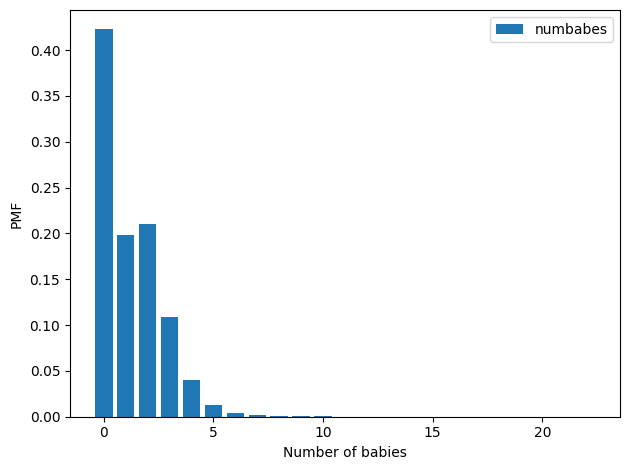

<IPython.core.display.Javascript object>

In [53]:
pmf.bar()
decorate(xlabel="Number of babies", ylabel="PMF")

In [54]:
# Solution

# The tail of the distribution extends farther right than left, so the
# distribution is skewed to the right

<IPython.core.display.Javascript object>

### Exercise

In the same way that the mean identifies a central point in a distribution, and variance quantifies its spread, there is another statistic, called **skewness**, that is intended to indicate whether a distribution is skewed to the left or right.

Given a sample, we can compute the skewness by computing the sum of the cubed deviations and dividing by the standard deviation cubed.
For example, here's how we compute the skewness of `numbabes`.


In [55]:
numbabes = resp["numbabes"].replace(97, np.nan)

<IPython.core.display.Javascript object>

In [56]:
deviations = numbabes - numbabes.mean()
skewness = np.mean(deviations**3) / numbabes.std(ddof=0) ** 3
skewness

1.7018914266755958

<IPython.core.display.Javascript object>

In general, a positive value indicates that a distribution is skewed to the right, and a negative value indicates that it is skewed to the left.

If you are given a `Pmf`, rather than a sequence of values, you can compute skewness like this:

1. Compute the deviation of each quantity in the `Pmf` from the mean.

2. Cube the deviations, multiply by the probabilities in the `Pmf`, and add up the products.

3. Divide the sum by the standard deviation cubed.

Write a function called `pmf_skewness` that takes a `Pmf` object and returns its skewness.

In [57]:
# Solution


def pmf_skewness(pmf):
    deviations = pmf.qs - pmf.mean()
    moment = np.sum(pmf.ps * deviations**3)
    return moment / pmf.std() ** 3

<IPython.core.display.Javascript object>

Use your function and the `Pmf` of `numbabes` to compute skewness, and confirm you get the same result.

In [58]:
# Solution

pmf_numbabes = Pmf.from_seq(numbabes)
pmf_skewness(pmf_numbabes)

1.7018914266755958

<IPython.core.display.Javascript object>

**Exercise:** Something like the class size paradox appears if you survey children and ask how many children are in their family.
Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

From `resp`, select `numkdhh`, which records the number of children under 18 in each respondent's household.
Make a `Pmf` of the values in this column.

Use the `bias` function to compute the distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

In [59]:
# Solution

num_kids = resp["numkdhh"]
Hist.from_seq(num_kids)

,freqs
numkdhh,
0,3563
1,1636
2,1500
3,666
4,196
5,82


<IPython.core.display.Javascript object>

In [60]:
# Solution

num_kids_pmf = Pmf.from_seq(num_kids, name="num_kids")
num_kids_biased = bias(pmf, name="biased")

<IPython.core.display.Javascript object>

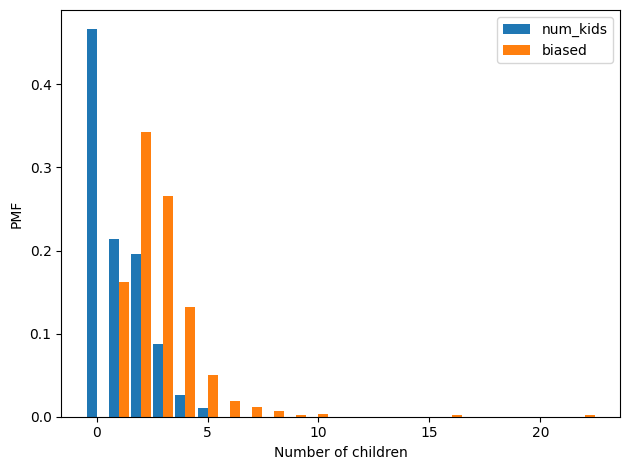

<IPython.core.display.Javascript object>

In [61]:
# Solution

two_bar_plots(num_kids_pmf, num_kids_biased)
decorate(xlabel="Number of children", ylabel="PMF")

In [62]:
# Solution

num_kids_pmf.mean(), num_kids_biased.mean()

(1.024205155043831, 2.8019039469461977)

<IPython.core.display.Javascript object>